# Load dataset

In [38]:
! pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [39]:
# Load Dataset

from datasets import load_dataset

ds = load_dataset("zoheb/sketch-scene")

split_ds = ds['train'].train_test_split(test_size = 0.1, seed=42)

train_ds = split_ds['train']
test_ds = split_ds['test']

Generating train split: 100%|██████████| 9999/9999 [00:00<00:00, 37925.97 examples/s]


In [40]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 9999
    })
})

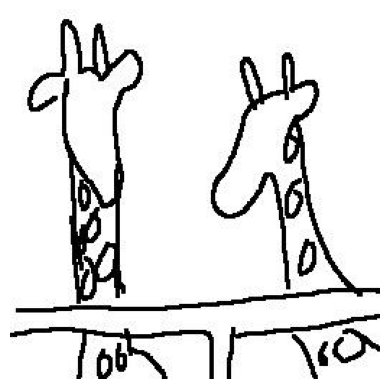

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x14D6DABE8320>, 'text': 'Two giraffe '}


In [41]:
from PIL import Image
import matplotlib.pyplot as plt
sample = ds['train'][50]
img = sample["image"]

plt.imshow(img)
plt.axis("off")
plt.show()

print(sample) 


In [42]:
img.size

(256, 256)

# Create Data Loaders

In [43]:
from torchvision import transforms

IMG_SIZE = 64

# define transform
transforms_img = [transforms.Resize((64, 64)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5]) if img.mode == 'L'
                    else transforms.Normalize([0.5]*3, [0.5]*3)
            ]

transform = transforms.Compose(transforms_img)

In [44]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SketchDataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img = self.ds[idx]['image']
        txt = self.ds[idx]['text']
        img = self.transform(img)
        return img, txt

train_dataset = SketchDataset(train_ds, transform)
test_dataset = SketchDataset(test_ds, transform)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


Text: A PERSON HOLDING A STICK


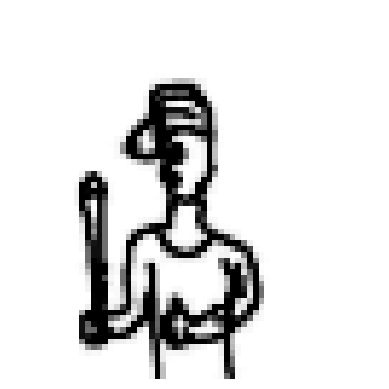

In [45]:
img, txt = train_dataset[59]
plt.imshow(img.permute(1,2,0))

plt.axis('off')
print("Text:", txt)
plt.show()


In [46]:
for batch in train_loader:
    for img in batch:
        print(img.shape)
        break
    break

torch.Size([16, 3, 64, 64])


# Forward Diffusion process

In [47]:
import torch

# Move all vars to GPU

device = "cuda"

# diffusion steps
T = 1000


# define beta and alphas
betas = torch.linspace(0.0001, 0.02, T).to(device)
alphas = (1 - betas).to(device)
alpha_bar = torch.cumprod(alphas, dim=0).to(device)


def sample_time_steps(batchsize):
    return torch.randint(0, T, (batchsize, ), device="cuda")

# forward process

def forward_diffusion(x0, t, noise=None):
    if noise == None:
        noise = torch.randn_like(x0)

    # specific syntax to do scalar multiplication over a matrix or broadcasting a value across input
    # across C, H, W
    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_1mab = torch.sqrt(1-alpha_bar[t])[:, None, None, None]

    return sqrt_ab*x0 + sqrt_1mab*noise


In [48]:

x0, txt = next(iter(train_loader)) 
x0 = x0.to(device)               

t = sample_time_steps(x0.size(0))  
noise = torch.randn_like(x0)     

x_t = forward_diffusion(x0, t, noise) 

print("Original batch shape:", x0.shape)
print("Diffused batch shape :", x_t.shape)


Original batch shape: torch.Size([16, 3, 64, 64])
Diffused batch shape : torch.Size([16, 3, 64, 64])


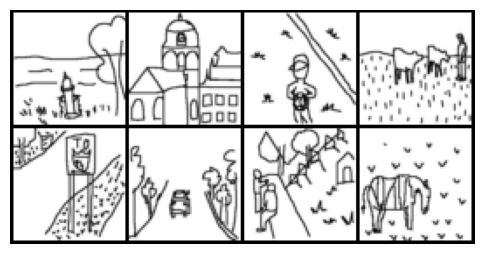

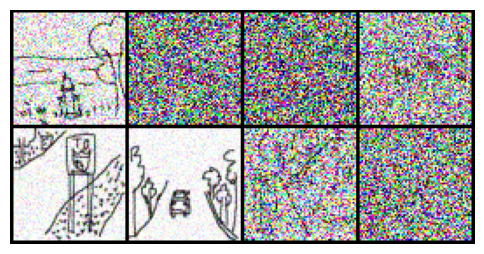

In [49]:
# Visualize

import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(x):
    grid = vutils.make_grid(x[:8], nrow=4, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

# original
show_images(x0)

# with added noise
show_images(x_t)


# Reverse Process with U-Net

In [74]:
import math
import torch.nn as nn
import torch.nn.functional as F

from transformers import CLIPTextModel, CLIPTokenizer

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

        # Freeze text encoder (because we don't want)
        for param in self.text_model.parameters():
            param.requires_grad = False

    def forward(self, text_prompts):
        # Tokenize
        tokens = self.tokenizer(text_prompts, padding=True, return_tensors="pt", truncation=True, max_length=77).to(self.text_model.device)

        # Get text embeddings
        outputs = self.text_model(**tokens)
        return outputs.last_hidden_state 

# turn timestep into a vector embedding that the main U-NET can use
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        self.mlp = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.SiLU(),
            nn.Linear(dim*4, dim)
        )

    def forward(self, t):
        # half sine and half cos waves
        half = self.dim//2

        freqs = torch.exp(-math.log(10000)* torch.arange(0, half, device=t.device) / half)

        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)

        # build embeddings
        embeddings = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

        return self.mlp(embeddings)

In [75]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, channels, context_dim=512, num_heads=8):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)

        self.context_proj = nn.Linear(context_dim, channels)
        self.attention = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            batch_first=True
        )

    def forward(self, x, context):

        batch, c, h, w = x.shape
        x_norm = self.norm(x)
        x_flat = x_norm.view(batch, c, h*w).transpose(1, 2)

        context_proj = self.context_proj(context)

        attn_out, _ = self.attention(query=x_flat, key=context_proj, value=context_proj)
        attn_out = attn_out.transpose(1, 2).view(batch, c, h, w)

        return x + attn_out


# Residual Block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, context_dim=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.time_proj = nn.Linear(time_dim, out_channels)

        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)

        # Cross-attention for text
        self.cross_attn = CrossAttentionBlock(out_channels, context_dim)

        self.act = nn.SiLU()
        self.skip = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t_emb, text_emb):
        h = self.conv1(x)

        # Add time embedding
        t_out = self.time_proj(t_emb)
        h = h + t_out[:, :, None, None]
        h = self.norm1(h)
        h = self.act(h)

        # Add text conditioning via cross-attention
        h = self.cross_attn(h, text_emb)

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.skip(x)

In [76]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, time_dim=256):
        super().__init__()

        self.time_mlp = TimeEmbedding(time_dim)
        self.text_encoder = TextEncoder()

        # downsampling
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.down1 = ResBlock(base_channels, base_channels, time_dim)
        self.down2 = ResBlock(base_channels, base_channels * 2, time_dim)
        self.down3 = ResBlock(base_channels * 2, base_channels * 4, time_dim)
        self.downsample1 = nn.Conv2d(base_channels, base_channels, 4, stride=2, padding=1)
        self.downsample2 = nn.Conv2d(base_channels * 2, base_channels * 2, 4, stride=2, padding=1)
        self.downsample3 = nn.Conv2d(base_channels * 4, base_channels * 4, 4, stride=2, padding=1)

        # bottleneck
        self.mid1 = ResBlock(base_channels * 4, base_channels * 4, time_dim)
        self.mid2 = ResBlock(base_channels * 4, base_channels * 4, time_dim)

        # upsampling
        self.upsample3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 4, stride=2, padding=1)
        self.up3 = ResBlock(base_channels * 4 + base_channels * 4, base_channels * 2, time_dim)

        self.upsample2 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 4, stride=2, padding=1)
        self.up2 = ResBlock(base_channels * 2 + base_channels * 2, base_channels, time_dim)

        self.upsample1 = nn.ConvTranspose2d(base_channels, base_channels, 4, stride=2, padding=1)
        self.up1 = ResBlock(base_channels + base_channels, base_channels, time_dim)

        # output
        self.conv_out = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, t, text_prompts=None):
        t_emb = self.time_mlp(t)

        # Text embeddinga
        if text_prompts is not None:
            text_emb = self.text_encoder(text_prompts)
        else:
            text_emb = self.text_encoder([""] * x.size(0))

        x0 = self.conv_in(x)

        d1 = self.down1(x0, t_emb, text_emb)  
        x_d1 = self.downsample1(d1)

        d2 = self.down2(x_d1, t_emb, text_emb) 
        x_d2 = self.downsample2(d2)

        d3 = self.down3(x_d2, t_emb, text_emb)
        x_d3 = self.downsample3(d3)

        m = self.mid1(x_d3, t_emb, text_emb) 
        m = self.mid2(m, t_emb, text_emb) 

        u3 = self.upsample3(m)
        u3 = torch.cat([u3, d3], dim=1) 
        u3 = self.up3(u3, t_emb, text_emb)

        u2 = self.upsample2(u3)
        u2 = torch.cat([u2, d2], dim=1) 
        u2 = self.up2(u2, t_emb, text_emb)

        u1 = self.upsample1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up1(u1, t_emb, text_emb)

        out = self.conv_out(u1)
        return out

# Training

In [93]:
device = "cuda"

model = UNet(in_channels=3, base_channels=64, time_dim=128).to(device)
# model = nn.DataParallel(model)

# eps_pred = model(x_t, t)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
num_epochs = 100


In [80]:
# training loop

import random

for epoch in range(num_epochs):
    for x0, captions in train_loader:
        x0 = x0.to(device)

        # sample random timesteps for x0
        t = sample_time_steps(x0.size(0)).to(device)

        # random gaussian noise
        noise = torch.randn_like(x0)

        # diffusion (forward process)
        x_t = forward_diffusion(x0, t, noise)

        # randomly drop text 10% of time
        if random.random() < 0.1:
            captions = [""] * len(captions)

        # predict noise with text conditioning
        noise_pred = model(x_t, t, captions)

        loss = loss_fn(noise_pred, noise)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}/{num_epochs}, Loss: {loss.item()}")
    if(epoch % 5 == 0):
        torch.save(model.state_dict(), f"conditional_ddpm_epoch_{epoch}.pth")

Epoch: 0/5, Loss: 0.06064177677035332
Epoch: 1/5, Loss: 0.01616845838725567
Epoch: 2/5, Loss: 0.014760326594114304
Epoch: 3/5, Loss: 0.023850934579968452
Epoch: 4/5, Loss: 0.01972317323088646


# Inference

In [109]:

from src.forward_process import sample_time_steps, forward_diffusion, show_images
from src.reverse_process_architecture import ResBlock, UNet
from src.load_sketch_data import data_loaders
from src.inference import sample_images_progress, save_video
import torch.nn as nn
import torch
import random
import os
import re

# this one function is from chatGPT cause I'm too excited to make it work before I code it out :))
def get_latest_checkpoint(prefix="conditional_ddpm_epoch_", suffix=".pth"):

    files = [f for f in os.listdir(".") if f.startswith(prefix) and f.endswith(suffix)]
    if not files:
        return None, 0

    # Extract epoch number using regex
    pattern = re.compile(rf"{prefix}(\d+){suffix}")
    epochs = []

    for f in files:
        match = pattern.match(f)
        if match:
            epochs.append((int(match.group(1)), f))

    if not epochs:
        return None, 0

    # Find the highest epoch number
    latest_epoch, latest_file = max(epochs, key=lambda x: x[0])
    return latest_file, latest_epoch

MODEL_PATH = "/home/jbu7511/Diffusion-from-scratch/best_model.pth"
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
print("Running inference...\n")
text_prompt = "Woman"

samples = sample_images_progress(
    model, T,
    num_images=4,
    img_size=64,
    save_every=5,
    text_prompt=text_prompt,
    guidance_scale=7.5,
)
save_video(samples,T,filename=text_prompt+".mp4", fps=20)
print("\nInference complete. Video saved!")


Running inference...



IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (140, 140) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[INFO] Writing video with 200 frames to Woman.mp4 ...
[INFO] Saved video to Woman.mp4

Inference complete. Video saved!
